In [25]:
import os

#1. Prepairing the Dataset

In [3]:
label_names = os.listdir()

In [4]:
class_mapping = dict()
class_ = 0
for i in label_names:
  class_mapping[i] = class_
  class_ = class_ + 1

In [5]:
class_mapping

{'.ipynb_checkpoints': 0,
 'Data': 1,
 'defense': 2,
 'Models': 3,
 'Shradha.ipynb': 4,
 'Testing_IRProject_Prabal.ipynb': 5}

In [ ]:
os.getcwd()

In [ ]:
path = '/content/drive/My Drive/IR/Label_Oxford/'

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import joblib
import pickle
import pandas as pd 
from matplotlib.pyplot import figure 

In [ ]:
import matplotlib.pyplot as plt
X = []
y = []

for folders in os.listdir():
  new_path = os.path.join(path,folders)
  label = class_mapping[folders]
  for images in os.listdir(new_path):
    img = cv2.imread(os.path.join(new_path,images))
    try:
      new_img = cv2.resize(img, (224, 224))
    except Exception as e:
      print(str(e))
    X.append(new_img)
    y.append(label)
  print('{} Completed'.format(folders))

In [27]:
# X = np.array(X)
# y = np.array(y)
# X = np.load(my_path+'\\Data\\X.npy')
# y = np.load(my_path+'\\Data\\y.npy')

In [7]:
X.shape, y.shape

((5063, 224, 224, 3), (5063,))

#Train Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
X_train.shape, X_test.shape

((3544, 224, 224, 3), (1519, 224, 224, 3))

In [ ]:
# np.save('Data/X.npy', X)
# np.save('Data/y.npy',y)

In [ ]:
#Trying from Here

In [29]:
x_train, x_test = X_train / 255.0, X_test / 255.0

In [30]:
from keras.applications import resnet50, inception_v3, vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
import numpy as np

VGG_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [31]:
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [32]:
feature_extractor=VGG_model.predict(x_train)

In [33]:
feature_extractor.shape

(3544, 7, 7, 512)

In [34]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

In [35]:
features.shape

(3544, 25088)

In [36]:
X_for_training = features #This is our X input to RF

#Classification 

## ResNet50

In [28]:
from keras.preprocessing import image
from keras.applications import resnet50, inception_v3, vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
import numpy as np

batch_size = 64
num_classes = 17

# base_model = resnet50.ResNet50
# base_model = inception_v3.InceptionV3
base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512,activation = 'relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [30]:
for layer in base_model.layers[16:]:
    layer.trainable = True
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [65]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])

X_train = vgg16.preprocess_input(X_train)

print(model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1))
model.fit(X_train, y_train,
          epochs=50,
          batch_size=batch_size,
          shuffle=False,
          validation_data=(X_test, y_test))

56/56 [==============================] - 26s 457ms/step - loss: 2.4273 - acc: 0.4016
[2.6391866207122803, 0.3710496723651886]
Epoch 1/50
56/56 [==============================] - 38s 661ms/step - loss: 2.6847 - acc: 0.3821 - val_loss: 2.8950 - val_acc: 0.2153
Epoch 2/50
56/56 [==============================] - 37s 660ms/step - loss: 1.6650 - acc: 0.5449 - val_loss: 2.8077 - val_acc: 0.2219
Epoch 3/50
56/56 [==============================] - 37s 661ms/step - loss: 1.1600 - acc: 0.6701 - val_loss: 2.8254 - val_acc: 0.2140
Epoch 4/50
56/56 [==============================] - 37s 664ms/step - loss: 0.8550 - acc: 0.7517 - val_loss: 2.8348 - val_acc: 0.2304
Epoch 5/50
56/56 [==============================] - 37s 663ms/step - loss: 0.6936 - acc: 0.7951 - val_loss: 2.8601 - val_acc: 0.2653
Epoch 6/50
56/56 [==============================] - 37s 664ms/step - loss: 0.6654 - acc: 0.7833 - val_loss: 2.8792 - val_acc: 0.2304
Epoch 7/50
56/56 [==============================] - 37s 665ms/step - loss: 0

In [59]:
p  =model.predict(X_test)

In [63]:
y_test

array([ 0, 10, 12, ..., 16,  6,  1], dtype=int64)

In [64]:
p[0]

array([2.1922882e-01, 1.0360672e-02, 4.8623523e-01, 5.0597073e-04,
       2.7847120e-03, 4.8698351e-02, 5.4136356e-03, 2.9683812e-03,
       5.9040233e-02, 2.3660345e-03, 4.5727510e-02, 1.0360456e-03,
       3.7263405e-02, 1.6640134e-02, 3.6938995e-02, 1.3838045e-04,
       2.4653489e-02], dtype=float32)

In [11]:
os.getcwd()

'C:\\Users\\Prabal\\Desktop\\IR Project'

In [12]:
os.getcwd()+'\\Models\\Resnet.h5'

'C:\\Users\\Prabal\\Desktop\\IR Project\\Models\\Resnet.h5'

In [13]:
# model.save(os.getcwd()+'\\Models\\Resnet.h5')

In [17]:
# from keras.preprocessing import image
from keras.applications import resnet50, inception_v3, vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
import numpy as np

batch_size = 64
num_classes = 17

# base_model = resnet50.ResNet50
base_model = inception_v3.InceptionV3
# base_model = vgg16.VGG16

base_model = base_model(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['acc'])


X_train = inception_v3.preprocess_input(X_train)

print(model.evaluate(X_train, y_train, batch_size=batch_size, verbose=1))
model.fit(X_train, y_train,
          epochs=50,
          batch_size=batch_size,
          shuffle=False,
          validation_data=(X_train, y_train))

111/111 [==============================] - 25s 205ms/step - loss: 0.0163 - acc: 1.0000


[0.016318481415510178, 1.0]

In [19]:
os.listdir()

['.ipynb_checkpoints',
 'Data',
 'defense',
 'Models',
 'New',
 'Part1',
 'Part2',
 'Shradha.ipynb',
 'Testing_IRProject_Prabal.ipynb']

In [26]:
os.getcwd()+'\\Part1\\'

'C:\\Users\\Prabal\\Desktop\\IR Project'

In [33]:
src_path = os.getcwd()+'\\Part2\\'
dst_path = os.getcwd()+'\\new\\'

In [34]:
# import shutil
# for folders in os.listdir(src_path):
#     print(folders+' Completed')
#     for image in os.listdir(os.path.join(src_path, folders)):
#         path = os.path.join(os.path.join(src_path, folders), image)
#         shutil.copy(path, dst_path)

All_Souls Completed
Ashmolean Completed
Balliol Completed
Bodleian Completed
Christ_Church Completed
Jesus Completed
Keble Completed
Magdalen Completed
New Completed
Oriel Completed
Oxford Completed
Pitt_Rivers Completed
Radcliffe_Camera Completed
Trinity Completed


In [ ]:
#Program Starts From Here (Image Retrieval)

In [31]:
import tensorflow as tf

In [32]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [33]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

In [34]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [35]:
test_path = os.getcwd()+'\\Data\\Apple_1.jpg'
print(test_path)

C:\Users\Prabal\Desktop\Anjali\Data\Apple_1.jpg


In [7]:
# model.summary()

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [37]:
img , x = load_image(test_path)

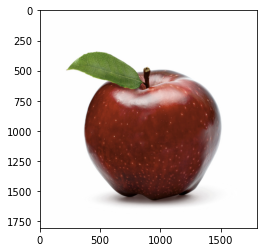

In [38]:
plt.imshow(plt.imread(test_path))

In [39]:
predictions = model.predict(x)

In [40]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
# feat_extractor.summary()

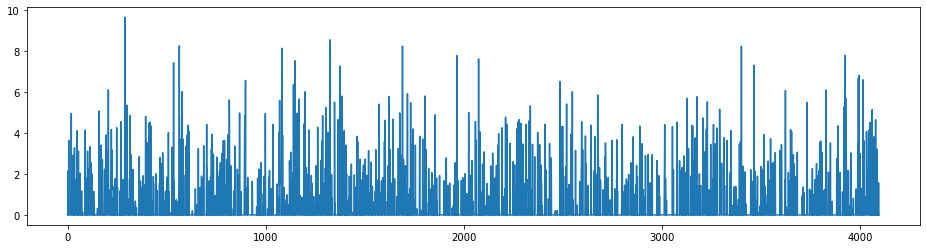

In [41]:
img, x = load_image(test_path)
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [42]:
#Retrieve temp
path = os.getcwd()+'\\Data'
temp = []
for name in os.listdir(path):
  temp.append(path+'\\'+name)

In [43]:
len(temp)

9533

In [ ]:
# import time
# tic = time.process_time()
# features = []
# for i, image_path in enumerate(temp):
#     print("analyzing image {}".format(i))
#     img, x = load_image(image_path);
#     feat = feat_extractor.predict(x)[0]
#     features.append(feat)
import time
tic = time.process_time()
features = []
temp2 = []
for i, image_path in enumerate(temp):
    print("analyzing image {}".format(i))
    try:
        img, x = load_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)
        temp2.append(temp[i])
    except Exception as e:
        print(str(e))

analyzing image 0
analyzing image 1
analyzing image 2
analyzing image 3
analyzing image 4
analyzing image 5
analyzing image 6
analyzing image 7
analyzing image 8
analyzing image 9
analyzing image 10
analyzing image 11
analyzing image 12
analyzing image 13
analyzing image 14
analyzing image 15
analyzing image 16
analyzing image 17
analyzing image 18
analyzing image 19
analyzing image 20
analyzing image 21
analyzing image 22
analyzing image 23
analyzing image 24
analyzing image 25
analyzing image 26
analyzing image 27
analyzing image 28
analyzing image 29
analyzing image 30
analyzing image 31
analyzing image 32
analyzing image 33
analyzing image 34
analyzing image 35
analyzing image 36
analyzing image 37
analyzing image 38
analyzing image 39
analyzing image 40
analyzing image 41
analyzing image 42
analyzing image 43
analyzing image 44
analyzing image 45
analyzing image 46
analyzing image 47
analyzing image 48
analyzing image 49
analyzing image 50
analyzing image 51
analyzing image 52
ana

In [ ]:
#Finding n_components from PCA.

In [44]:
# 'C:\\Users\\Prabal\\Desktop\\Report\\Images\\Oxford\\Features\\VGG16F.npy'
'C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16F.npy' 

'C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16F.npy'

In [22]:
import numpy as np
# np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16F.npy' ,np.array(features))

In [46]:
features = np.load('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16F.npy')

In [19]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=1000)
pca.fit(features)
pca_features = pca.transform(features)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import plotly.express as px
fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
    )
fig.show()

In [47]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [48]:
type(pca_features)

numpy.ndarray

In [28]:
# import pickle
# filename = 'C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\pca'
# pickle.dump(pca, open(filename, 'wb'))
# np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16PCAF.npy',pca_features)

In [46]:
# np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16PCAF.npy',pca_features)

In [27]:
# pca_features = np.load('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\VGG16PCAF.npy')

Total time : 0.6734668000008242 seconds


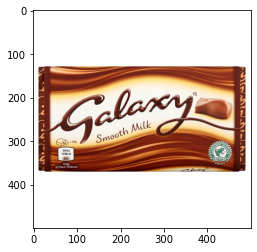

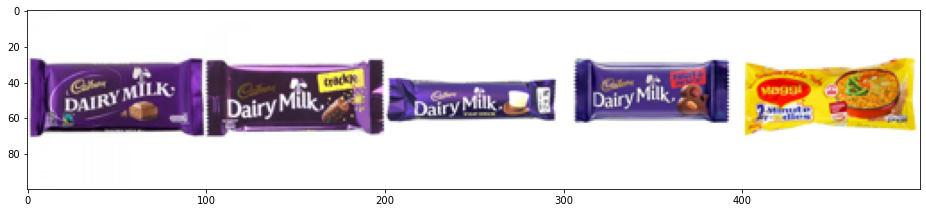

In [49]:
import random
import time
# grab a random query image
query_image_idx = int(2600 * random.random())

# let's display the image
img = image.load_img(temp[query_image_idx])

start = time.perf_counter()
plt.imshow(img)
from scipy.spatial import distance
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
thumbs = []
for idx in idx_closest:
    img = image.load_img(temp[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

end = time.perf_counter()    
# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)
print('Total time : {} seconds'.format(end-start))

In [61]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [50]:
dict_path = 'C:\\Users\\Prabal\\Desktop\\Anjali\\Dataset\\'
my_dict = dict()
c=0
for folder in os.listdir(dict_path):
    my_dict[folder] = c
    c =c+1
def findClass(index):
    return my_dict[temp[index].split('\\')[-1].split('_')[0]]

In [51]:
def getAccuracy(q,r):
    count=0
    for i in r:
        if q ==i:
            count = count+1
    return count*100/len(r)

In [23]:
from scipy.spatial import distance
import random
from tqdm import tqdm
def evaluation(n_samples):
    acc_avg = 0
    time_avg = 0
    for i in tqdm(range(n_samples)):
        print(i)
        query_image_idx = int(300 * random.random())
        class_q = findClass(query_image_idx)
        class_r = list()
        start = time.perf_counter()
        similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
        idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
        thumbs = []
        for idx in idx_closest:
            img = image.load_img(temp2[idx])
            class_r.append(findClass(idx))
            img = img.resize((int(img.width * 100 / img.height), 100))
            thumbs.append(img)
        end = time.perf_counter()
#         print('Total time : {} seconds'.format(end-start))
#         print('Accuracy is {}'.format(getAccuracy(class_q, class_r)))
        acc_avg = acc_avg + getAccuracy(class_q, class_r)
        time_avg = (end-start)+time_avg
    print('Final accuracy on {} random samples on VGG16 (CBIR) {}'.format(n_samples,acc_avg/n_samples))
    print('Average time per sample {}'.format(time_avg/n_samples))
evaluation(5)

In [72]:
#Testing Time :
from scipy.spatial import distance
from tqdm import tqdm
def evaluation__(sample_index):
    acc_avg = 0
    time_avg = 0
    query_image_idx = sample_index
    class_q = findClass(query_image_idx)
    class_r = list()
    start = time.perf_counter()
    similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
    thumbs = []
    for idx in idx_closest:
        img = image.load_img(temp[idx])
        class_r.append(findClass(idx))
        img = img.resize((int(img.width * 100 / img.height), 100))
        thumbs.append(img)
    end = time.perf_counter()
    acc_avg = acc_avg + getAccuracy(class_q, class_r)
    time_avg = (end-start)+time_avg
    return (time_avg, acc_avg)

import time
j =0
class_acc  =[]
for class_ in my_dict.keys():
    name = class_
    print(name)
    count =0
    temp_list = list()
    for i in range(len(temp)):
        if(temp[i].split('\\')[-1].split('_')[0] == name):
            if count>4:
                break
            temp_list.append((class_,evaluation__(i)))
            count = count +1
    class_acc.append(temp_list)

Apple
BarackObama
Bikes
Bottle
Buddha
Butterfly
Camera
Car
Cat
Chair
Chocolate
Clock
Cocacola
DairyMilk
Dalmatian
Desert
EiffelTower
Elephant
Helmet
Horse
IndiaGate
Jeans
Kangaroo
Lotus
Maggi
Mango
Mobile
NarendraModi
Peacock
Rose
SachinTendulkar
SalmanKhan
Shark
Sheep
Ship
Shirt
Shoes
SoccerBall
Sunflower
Tabla
TajMahal
Television
Tiger
TrafficLight
Vase
Vulture
Waterfall
Watermelon
Wine
Zebra


In [76]:
temp_ = list()
for i in class_acc:
    t =0
    a =0
    temp2 = list()
    if(len(i)==0):
        continue
    for index in range(4):
        name = i[index][0]
        t = t + i[index][1][0]
        a = a +i[index][1][1]
    temp2.append(name)
    temp2.append(t/5)
    temp2.append(a/5)
    temp_.append(temp2)

In [77]:
result_VGG16 = pd.DataFrame(temp_)
result_VGG16.columns = ['Class', 'Time', 'Accuracy']
result_VGG16

Class      Time  Accuracy
0             Apple  0.512563      48.0
1       BarackObama  0.507843      68.0
2             Bikes  0.568922      80.0
3            Bottle  0.552717      60.0
4            Buddha  0.537867      80.0
5         Butterfly  0.591876      80.0
6            Camera  0.537624      80.0
7               Car  0.564227      80.0
8               Cat  0.506257      80.0
9             Chair  0.516841      60.0
10        Chocolate  0.537754      80.0
11            Clock  0.518925      80.0
12         Cocacola  0.546117      72.0
13        DairyMilk  0.486143      60.0
14        Dalmatian  0.507547      80.0
15           Desert  0.847606      72.0
16      EiffelTower  0.497991      80.0
17         Elephant  0.490831      80.0
18           Helmet  0.478454      80.0
19            Horse  0.499299      76.0
20        IndiaGate  0.535019      80.0
21            Jeans  0.481927      80.0
22         Kangaroo  0.585811      80.0
23            Lotus  0.522139      76.0
24            Maggi  0.480879      80.0
25            Mango  0.531652      48.0
26           Mobile  0.453329      80.0
27     NarendraModi  0.469858      80.0
28          Peacock  0.546980      80.0
29             Rose  0.602712      80.0
30  SachinTendulkar  0.464489      52.0
31       SalmanKhan  0.512376      60.0
32            Shark  0.573085      72.0
33            Sheep  0.579918      80.0
34             Ship  0.742079      80.0
35            Shirt  0.472727      80.0
36            Shoes  0.487271      80.0
37       SoccerBall  0.530303      80.0
38        Sunflower  0.593744      60.0
39            Tabla  0.539220      80.0
40         TajMahal  0.585583      80.0
41       Television  0.477701      80.0
42            Tiger  0.621763      80.0
43     TrafficLight  0.497839      80.0
44             Vase  0.470490      72.0
45          Vulture  0.535758      76.0
46        Waterfall  0.583268      80.0
47       Watermelon  0.498992      64.0
48             Wine  0.518466      80.0
49            Zebra  0.551148      80.0

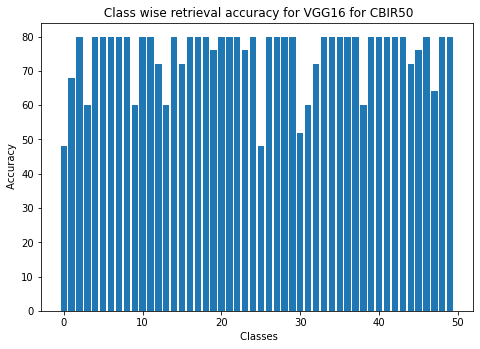

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = result_VGG16.Accuracy.values
x= [i for i in range(50)]
ax.bar(x,y)
ax.set_xlabel(" Classes")
ax.set_ylabel(" Accuracy")
plt.title(" Class wise retrieval accuracy for VGG16 for CBIR50")
plt.show()

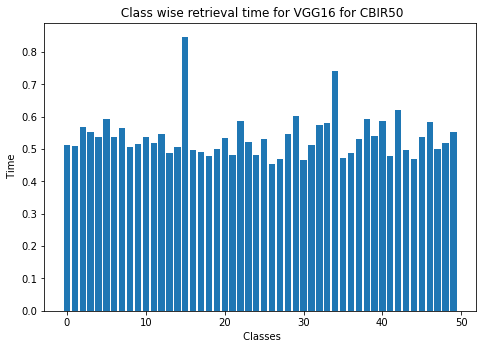

In [79]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = result_VGG16.Time.values
x= [i for i in range(50)]
ax.bar(x,y)
ax.set_xlabel(" Classes")
ax.set_ylabel(" Time")
plt.title(" Class wise retrieval time for VGG16 for CBIR50")
plt.show()

In [94]:
result_VGG16.Accuracy.values

array([48., 68., 80., 60., 80., 80., 80., 80., 80., 60., 80., 80., 72.,
       60., 80., 72., 80., 80., 80., 76., 80., 80., 80., 76., 80., 48.,
       80., 80., 80., 80., 48., 60., 72., 80., 80., 80., 80., 80., 60.,
       80., 80., 80., 80., 80., 72., 76., 80., 64., 80., 80.])

In [45]:
n = every_class[0][0]

In [58]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [36]:
# Trying Inceptionv3

In [80]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D


model = keras.applications.InceptionV3(weights='imagenet', include_top=True)

feat_extractor = Model(inputs=model.input, outputs=model.get_layer('mixed7').output)
feat_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [81]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

shape of x:  (1, 299, 299, 3)
data type:  float32


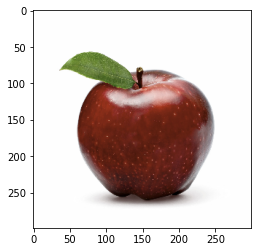

In [82]:
img, x = load_image(temp[0])
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [ ]:
import time
tic = time.process_time()

features = []
for i, image_path in enumerate(temp):
    print("analyzing image {}".format(i))
    img, x = load_image(image_path);
    feat = model.predict(x)[0]
    features.append(feat)

# import time
# tic = time.process_time()
# features = []
# # temp2 = []
# for i, image_path in enumerate(temp):
#     print("analyzing image {}".format(i))
#     try:
#         img, x = load_image(image_path);
#         feat = feat_extractor.predict(x)[0]
#         features.append(feat)
# #         temp2.append(temp[i])
#     except Exception as e:
#         print(str(e))

In [112]:
len(features)

9533

In [107]:
features[-1]

array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       , 26.077581 ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       , 39.03567  ,  0.       , ...,  0.       ,
          0.       ,  0.       ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.

In [113]:
import numpy as np
np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\InceptionF.npy',np.array(features))

In [84]:
import numpy as np
len(features)
features = np.load('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\InceptionF.npy')

In [85]:
from sklearn.decomposition import PCA
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

In [86]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import plotly.express as px
fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
    )
fig.show()

In [87]:
features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)
pca_features = pca.transform(features)

In [88]:
pca_features.shape

(9533, 300)

In [78]:
import pickle
filename = 'C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\pcaInception_300'
pickle.dump(pca, open(filename, 'wb'))

Total time : 0.6704181999998582 seconds


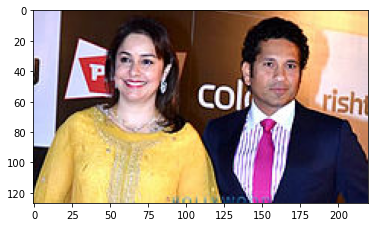

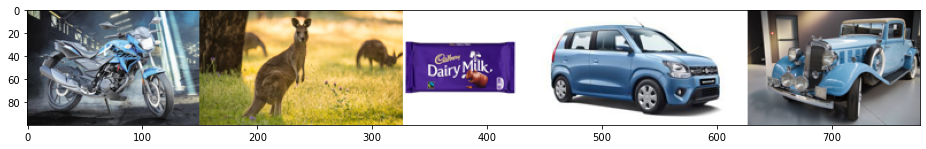

In [89]:
import random
# grab a random query image
query_image_idx = int(7000 * random.random())
# let's display the image
img = image.load_img(temp[query_image_idx])
start = time.perf_counter()
plt.imshow(img)
from scipy.spatial import distance
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
thumbs = []
for idx in idx_closest:
    img = image.load_img(temp[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

end = time.perf_counter()    
# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)
print('Total time : {} seconds'.format(end-start))

In [90]:
#Testing Time :
from scipy.spatial import distance
from tqdm import tqdm
def evaluation__(sample_index):
    acc_avg = 0
    time_avg = 0
    query_image_idx = sample_index
    class_q = findClass(query_image_idx)
    class_r = list()
    start = time.perf_counter()
    similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
    thumbs = []
    for idx in idx_closest:
        img = image.load_img(temp[idx])
        class_r.append(findClass(idx))
        img = img.resize((int(img.width * 100 / img.height), 100))
        thumbs.append(img)
    end = time.perf_counter()
    acc_avg = acc_avg + getAccuracy(class_q, class_r)
    time_avg = (end-start)+time_avg
    return (time_avg, acc_avg)

import time
j =0
class_acc  =[]
for class_ in my_dict.keys():
    name = class_
    print(name)
    count =0
    temp_list = list()
    for i in range(len(temp)):
        if(temp[i].split('\\')[-1].split('_')[0] == name):
            if count>4:
                break
            temp_list.append((class_,evaluation__(i)))
            count = count +1
    class_acc.append(temp_list)

Apple
BarackObama
Bikes
Bottle
Buddha
Butterfly
Camera
Car
Cat
Chair
Chocolate
Clock
Cocacola
DairyMilk
Dalmatian
Desert
EiffelTower
Elephant
Helmet
Horse
IndiaGate
Jeans
Kangaroo
Lotus
Maggi
Mango
Mobile
NarendraModi
Peacock
Rose
SachinTendulkar
SalmanKhan
Shark
Sheep
Ship
Shirt
Shoes
SoccerBall
Sunflower
Tabla
TajMahal
Television
Tiger
TrafficLight
Vase
Vulture
Waterfall
Watermelon
Wine
Zebra


In [91]:
temp_ = list()
for i in class_acc:
    t =0
    a =0
    temp2 = list()
    if(len(i)==0):
        continue
    for index in range(4):
        name = i[index][0]
        t = t + i[index][1][0]
        a = a +i[index][1][1]
    temp2.append(name)
    temp2.append(t/5)
    temp2.append(a/5)
    temp_.append(temp2)

In [92]:
result_Inceptionv3 = pd.DataFrame(temp_)
result_Inceptionv3.columns = ['Class', 'Time', 'Accuracy']
result_Inceptionv3

Class      Time  Accuracy
0             Apple  0.497176      80.0
1       BarackObama  0.513165       8.0
2             Bikes  0.541037       8.0
3            Bottle  0.523157       0.0
4            Buddha  0.500361       0.0
5         Butterfly  0.562294       0.0
6            Camera  0.546832       0.0
7               Car  0.542342       4.0
8               Cat  0.466212       0.0
9             Chair  0.559450       0.0
10        Chocolate  0.504554      20.0
11            Clock  0.503543       0.0
12         Cocacola  0.500157       0.0
13        DairyMilk  0.568344       0.0
14        Dalmatian  0.490864       4.0
15           Desert  0.466906       8.0
16      EiffelTower  0.471052       0.0
17         Elephant  0.564769       4.0
18           Helmet  0.545738       0.0
19            Horse  0.476993       0.0
20        IndiaGate  0.493091       8.0
21            Jeans  0.497226       4.0
22         Kangaroo  0.594193       0.0
23            Lotus  0.523499       4.0
24            Maggi  0.492655       4.0
25            Mango  0.536596       0.0
26           Mobile  0.513455       0.0
27     NarendraModi  0.474894       4.0
28          Peacock  0.601063       0.0
29             Rose  0.476506       0.0
30  SachinTendulkar  0.473989       0.0
31       SalmanKhan  0.563391      16.0
32            Shark  0.473945       0.0
33            Sheep  0.543744       4.0
34             Ship  0.593149       0.0
35            Shirt  0.560189       0.0
36            Shoes  0.507306       8.0
37       SoccerBall  0.505101       0.0
38        Sunflower  0.495088       4.0
39            Tabla  0.542233       8.0
40         TajMahal  0.479801       4.0
41       Television  0.530007       0.0
42            Tiger  0.514709       8.0
43     TrafficLight  0.544279       4.0
44             Vase  0.489090       0.0
45          Vulture  0.476124       8.0
46        Waterfall  0.601026       0.0
47       Watermelon  0.515970       0.0
48             Wine  0.525054       8.0
49            Zebra  0.476966       0.0

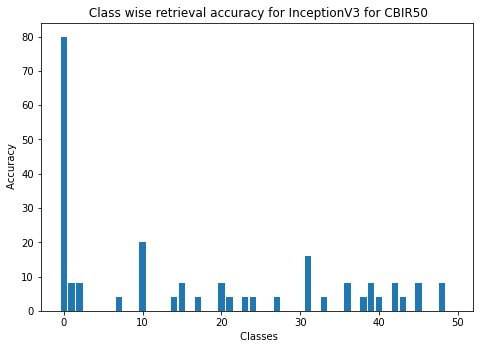

In [93]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]
y = result_Inceptionv3.Accuracy.values
x= [i for i in range(50)]
ax.bar(x,y)
ax.set_xlabel(" Classes")
ax.set_ylabel(" Accuracy")
plt.title(" Class wise retrieval accuracy for InceptionV3 for CBIR50")
plt.show()

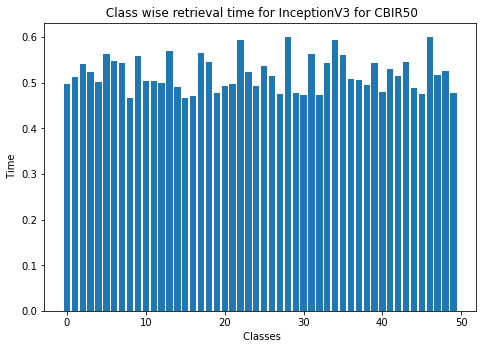

In [94]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]
y = result_Inceptionv3.Time.values
x= [i for i in range(50)]
ax.bar(x,y)
ax.set_xlabel(" Classes")
ax.set_ylabel(" Time")
plt.title(" Class wise retrieval time for InceptionV3 for CBIR50")
plt.show()

In [127]:
#ResNet50

In [95]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50

model = keras.applications.ResNet50(weights='imagenet', include_top=True)

feat_extractor = model
# feat_extractor.summary()

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape of x:  (510, 700, 3)
data type:  float32


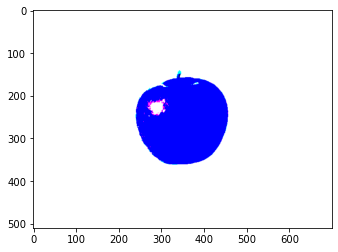

In [97]:
x = preprocess_input(plt.imread(temp[100]))
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(x)

In [141]:
import time
import cv2
tic = time.process_time()

features = []
for i, image_path in enumerate(temp):
    if i % 10 == 0:
        print("analyzing image {}".format(i))
    orig = cv2.imread(image_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    image = cv2.resize(orig, (224, 224)).reshape(-1, 224, 224, 3)
    image = preprocess_input(image)
    feat = model.predict(image)[0]
    features.append(feat)

analyzing image 0
analyzing image 10
analyzing image 20
analyzing image 30
analyzing image 40
analyzing image 50
analyzing image 60
analyzing image 70
analyzing image 80
analyzing image 90
analyzing image 100
analyzing image 110
analyzing image 120
analyzing image 130
analyzing image 140
analyzing image 150
analyzing image 160
analyzing image 170
analyzing image 180
analyzing image 190
analyzing image 200
analyzing image 210
analyzing image 220
analyzing image 230
analyzing image 240
analyzing image 250
analyzing image 260
analyzing image 270
analyzing image 280
analyzing image 290
analyzing image 300
analyzing image 310
analyzing image 320
analyzing image 330
analyzing image 340
analyzing image 350
analyzing image 360
analyzing image 370
analyzing image 380
analyzing image 390
analyzing image 400
analyzing image 410
analyzing image 420
analyzing image 430
analyzing image 440
analyzing image 450
analyzing image 460
analyzing image 470
analyzing image 480
analyzing image 490
analyzing i

TypeError: Can't convert object of type 'float' to 'str' for 'filename'

In [142]:
import numpy as np
np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\ResNetF.npy',np.array(features))

In [98]:
features = np.load('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\ResNetF.npy')

In [99]:
len(features)

9533

In [100]:
from sklearn.decomposition import PCA
features = np.array(features)
pca = PCA(n_components=1000)
pca.fit(features)
pca_features = pca.transform(features)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import plotly.express as px
fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
    )
fig.show()

In [101]:
features = np.array(features)
pca = PCA(n_components=400)
pca.fit(features)
pca_features = pca.transform(features)

In [21]:
import numpy as np
# np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\ResNetF.npy',features)
np.save('C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\ResnetPCAF.npy',np.array(pca_features))

In [165]:
import pickle
filename = 'C:\\Users\\Prabal\\Desktop\\Report\\Images\\CBIR\\Features\\pcaResNet_300'
pickle.dump(pca, open(filename, 'wb'))

In [166]:
type(pca_features)

numpy.ndarray

In [167]:
query_image_idx

53

In [102]:
dict_path = 'C:\\Users\\Prabal\\Desktop\\Anjali\\Dataset\\'
my_dict = dict()
c=0
for folder in os.listdir(dict_path):
    my_dict[folder] = c
    c =c+1
def findClass(index):
    return my_dict[temp[index].split('\\')[-1].split('_')[0]]


In [103]:
def getAccuracy(q,r):
    count=0
    for i in r:
        if q ==i:
            count = count+1
    return count*100/len(r)

Total time : 0.6252635999999256 seconds
Accuracy is 100.0


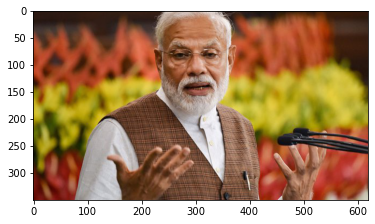

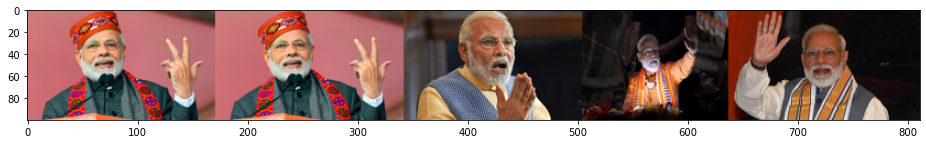

In [104]:
import random
import time
# grab a random query image
query_image_idx = int(7000 * random.random())
class_q = findClass(query_image_idx)
class_r = list()

# let's display
start = time.perf_counter()
plt.imshow(plt.imread(temp[query_image_idx]))
from scipy.spatial import distance
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
thumbs = []

for idx in idx_closest:
    img = image.load_img(temp[idx])
    class_r.append(findClass(idx))
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

end = time.perf_counter()    
# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)
print('Total time : {} seconds'.format(end-start))
print('Accuracy is {}'.format(getAccuracy(class_q, class_r)))

In [105]:
#Testing Time :
from scipy.spatial import distance
from tqdm import tqdm
def evaluation__(sample_index):
    acc_avg = 0
    time_avg = 0
    query_image_idx = sample_index
    class_q = findClass(query_image_idx)
    class_r = list()
    start = time.perf_counter()
    similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]
    thumbs = []
    for idx in idx_closest:
        img = image.load_img(temp[idx])
        class_r.append(findClass(idx))
        img = img.resize((int(img.width * 100 / img.height), 100))
        thumbs.append(img)
    end = time.perf_counter()
    acc_avg = acc_avg + getAccuracy(class_q, class_r)
    time_avg = (end-start)+time_avg
    return (time_avg, acc_avg)

import time
j =0
class_acc  =[]
for class_ in my_dict.keys():
    name = class_
    print(name)
    count =0
    temp_list = list()
    for i in range(len(temp)):
        if(temp[i].split('\\')[-1].split('_')[0] == name):
            if count>4:
                break
            temp_list.append((class_,evaluation__(i)))
            count = count +1
    class_acc.append(temp_list)

Apple
BarackObama
Bikes
Bottle
Buddha
Butterfly
Camera
Car
Cat
Chair
Chocolate
Clock
Cocacola
DairyMilk
Dalmatian
Desert
EiffelTower
Elephant
Helmet
Horse
IndiaGate
Jeans
Kangaroo
Lotus
Maggi
Mango
Mobile
NarendraModi
Peacock
Rose
SachinTendulkar
SalmanKhan
Shark
Sheep
Ship
Shirt
Shoes
SoccerBall
Sunflower
Tabla
TajMahal
Television
Tiger
TrafficLight
Vase
Vulture
Waterfall
Watermelon
Wine
Zebra


In [106]:
temp_ = list()
for i in class_acc:
    t =0
    a =0
    temp2 = list()
    if(len(i)==0):
        continue
    for index in range(4):
        name = i[index][0]
        t = t + i[index][1][0]
        a = a +i[index][1][1]
    temp2.append(name)
    temp2.append(t/5)
    temp2.append(a/5)
    temp_.append(temp2)

In [107]:
import pandas as pd
result_ResNet50 = pd.DataFrame(temp_)
result_ResNet50.columns = ['Class', 'Time', 'Accuracy']
result_ResNet50

Class      Time  Accuracy
0             Apple  0.511157      44.0
1       BarackObama  0.563393      52.0
2             Bikes  0.611492      76.0
3            Bottle  0.519836      68.0
4            Buddha  0.532895      56.0
5         Butterfly  0.927629      80.0
6            Camera  0.488716      80.0
7               Car  0.496173      80.0
8               Cat  0.513429      80.0
9             Chair  0.531707      80.0
10        Chocolate  0.752429      40.0
11            Clock  0.538099      80.0
12         Cocacola  0.514291      56.0
13        DairyMilk  0.481646      28.0
14        Dalmatian  0.559186      80.0
15           Desert  0.803080      44.0
16      EiffelTower  0.524243      68.0
17         Elephant  0.677637      76.0
18           Helmet  0.468894      80.0
19            Horse  0.532375      60.0
20        IndiaGate  0.516393      80.0
21            Jeans  0.501965      56.0
22         Kangaroo  0.504608      56.0
23            Lotus  0.522175      60.0
24            Maggi  0.561497      76.0
25            Mango  0.545726      40.0
26           Mobile  0.584049      80.0
27     NarendraModi  0.512816      32.0
28          Peacock  0.548625      80.0
29             Rose  0.738988      52.0
30  SachinTendulkar  0.475780      32.0
31       SalmanKhan  0.667576      32.0
32            Shark  0.531927      64.0
33            Sheep  0.526775      68.0
34             Ship  0.565231      80.0
35            Shirt  0.586019      76.0
36            Shoes  0.557125      80.0
37       SoccerBall  0.516737      80.0
38        Sunflower  0.511686      40.0
39            Tabla  0.505221      80.0
40         TajMahal  0.571553      48.0
41       Television  0.561935      80.0
42            Tiger  0.580079      80.0
43     TrafficLight  0.482152      64.0
44             Vase  0.487292      76.0
45          Vulture  0.503948      80.0
46        Waterfall  0.576952      64.0
47       Watermelon  0.576201      64.0
48             Wine  0.541667      76.0
49            Zebra  0.542357      80.0

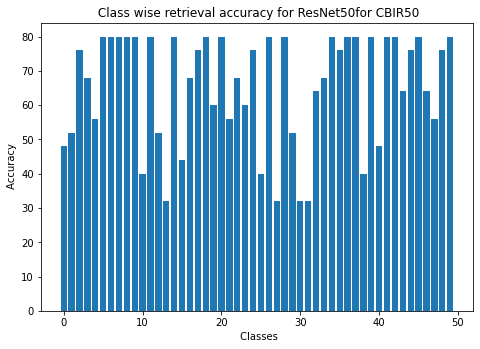

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
# langs = ['C', 'C++', 'Java', 'Python', 'PHP']
# students = [23,17,35,29,12]
y = result_ResNet50.Accuracy.values
x= [i for i in range(50)]
ax.bar(x,y)
ax.set_xlabel(" Classes")
ax.set_ylabel(" Accuracy")
plt.title(" Class wise retrieval accuracy for ResNet50for CBIR50")
plt.show()

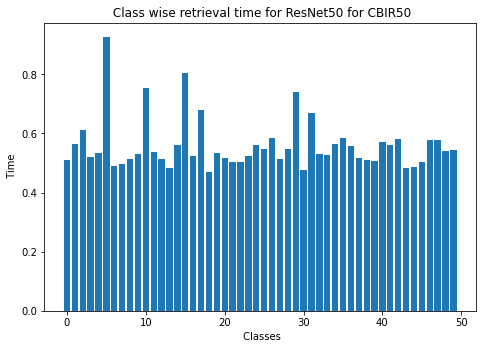

In [108]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = result_ResNet50.Time.values
x= [i for i in range(50)]
ax.bar(x,y)
ax.set_xlabel(" Classes")
ax.set_ylabel(" Time")
plt.title(" Class wise retrieval time for ResNet50 for CBIR50")
plt.show()